## Connected to the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Flatten, Dense, Dropout, Reshape
from sklearn.model_selection import train_test_split
import keras


## Dataset Preparation



*   In this part, we are sampling the audio to 16000 sample with the frequency of 16 khz, which gives us the total duration of 1 second per audio.
*   From this we can devide the number of samples by any number we can, creating a new dataset




In [ ]:
import os
import numpy as np
import librosa
import glob

# Path to the dataset folders
yes_drone_path = '/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/yes_drone'
no_drone_path = '/content/drive/MyDrive/TinyML_Dataset/DroneAudioDataset-master/Binary_Drone_Audio/unknown'

def load_audio_files_from_directory(directory_path, label, target_length=16000):
    """
    Loads all .wav files in a directory, preprocesses them, and assigns a label.
    """
    data = []
    labels = []

    # Find all .wav files in the directory
    for file_path in glob.glob(os.path.join(directory_path, '*.wav')):
        # Load audio file with librosa
        audio, sr = librosa.load(file_path, sr=16000)  # Resample to 16 kHz

        # Pad or truncate audio to match the target length
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), "constant")
        else:
            audio = audio[:target_length]

        # Append to data list
        data.append(audio)
        labels.append(label)  # Assign the given label (1 for "yes_drone", 0 for "no_drone")

    # Convert lists to numpy arrays
    data = np.array(data).reshape(-1, target_length, 1)  # Shape: (num_samples, 2047, 1)
    labels = np.array(labels)  # Shape: (num_samples,)
    return data, labels

# Load data from each class
X_yes_drone, y_yes_drone = load_audio_files_from_directory(yes_drone_path, label=1)
X_no_drone, y_no_drone = load_audio_files_from_directory(no_drone_path, label=0)

# Combine "yes_drone" and "no_drone" datasets
X_data = np.concatenate([X_yes_drone, X_no_drone], axis=0)
y_data = np.concatenate([y_yes_drone, y_no_drone], axis=0)

# Shuffle the data
indices = np.arange(X_data.shape[0])
np.random.shuffle(indices)
X_data = X_data[indices]
y_data = y_data[indices]

# Print the shape of the dataset
print("Shape of X_data:", X_data.shape)  # Should be (total_samples, 16000, 1)
print("Shape of y_data:", y_data.shape)  # Should be (total_samples,)


Shape of X_data: (11704, 16000, 1)
Shape of y_data: (11704,)


## Save the prepared Dataset

In [ ]:
# Define paths for saving the data
X_data_path = '/content/drive/MyDrive/TinyML_Dataset/X_data.npy'
y_data_path = '/content/drive/MyDrive/TinyML_Dataset/y_data.npy'

# Save X_data and y_data to Google Drive
np.save(X_data_path, X_data)
np.save(y_data_path, y_data)

print("Data saved to Google Drive successfully.")


Data saved to Google Drive successfully.


# 1s of audio duration

In [ ]:
# Define paths for saving the data
X_data_path = '/content/drive/MyDrive/TinyML_Dataset/X_data.npy'
y_data_path = '/content/drive/MyDrive/TinyML_Dataset/y_data.npy'

# Load X_data and y_data from Google Drive
X_data = np.load(X_data_path)
y_data = np.load(y_data_path)

print("Data loaded from Google Drive successfully.")
print("Shape of X_data:", X_data.shape)
print("Shape of y_data:", y_data.shape)


Data loaded from Google Drive successfully.
Shape of X_data: (11704, 16000, 1)
Shape of y_data: (11704,)


## 1s model Configuration

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Model configuration
input_shape = (16000, 1)
num_classes = 2  # Binary classification ("yes_drone" and "no_drone")

# Build the model
model1 = Sequential()

# Reshape layer
model1.add(Reshape((16000, 1), input_shape=input_shape))

# Convolutional Layers with Pooling
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model1.add(AveragePooling1D(pool_size=2))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(AveragePooling1D(pool_size=2))
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model1.add(AveragePooling1D(pool_size=2))
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model1.add(AveragePooling1D(pool_size=2))

# Dropout for regularization
model1.add(Dropout(0.2))  # Increased dropout rate

# Flattening and Dense layers
model1.add(Flatten())
model1.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Reduced size, added L2 regularization
model1.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # L2 regularization added

# Compile the model with binary crossentropy for binary classification
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model1.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_9 (Reshape)                  │ (None, 16000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 15998, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 7999, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7997, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, 3998, 64)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3996, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_2                  │ (None, 1998, 128)           │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1996, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_3                  │ (None, 998, 128)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 998, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 127744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │      16,351,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,431,809 (62.68 MB)

 Trainable params: 16,431,809 (62.68 MB)

 Non-trainable params: 0 (0.00 B)

## 1s spliting Dataset into: Training, Validation and Test

In [ ]:
from sklearn.model_selection import train_test_split

# Define paths for saving the data
X_data_path = '/content/drive/MyDrive/TinyML_Dataset/X_data.npy'
y_data_path = '/content/drive/MyDrive/TinyML_Dataset/y_data.npy'

# Load X_data and y_data from Google Drive
X_data = np.load(X_data_path)
y_data = np.load(y_data_path)

print("Data loaded from Google Drive successfully.")
print("Shape of X_data:", X_data.shape)
print("Shape of y_data:", y_data.shape)

# Step 1: Split into 85% train+validation and 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42)

# Step 2: Split train+validation (85%) into 70% training and 15% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)
# 0.1765 because 15% / 85% ≈ 0.1765

# Print shapes of the splits
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


Data loaded from Google Drive successfully.
Shape of X_data: (11704, 16000, 1)
Shape of y_data: (11704,)
Training data shape: (8192, 16000, 1)
Validation data shape: (1756, 16000, 1)
Test data shape: (1756, 16000, 1)


## Training the model

In [ ]:
# Train the model on training and validation data
batch_size = 50  # Adjust based on memory availability
epochs = 100   # Number of epochs for training

history = model1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),  # Validation data for monitoring
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


NameError: name 'model1' is not defined

## Monitoring the optimized Model

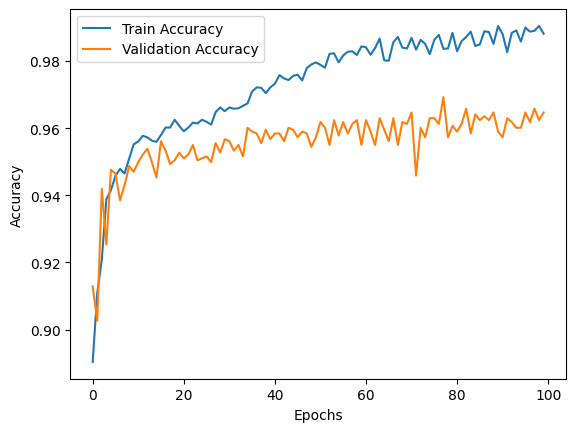

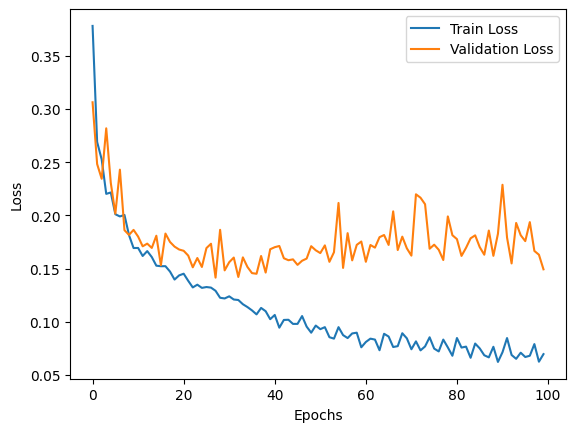

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 1s model transformation to TFL (TensorFlow Lite)

In [ ]:
model1.save("/content/drive/MyDrive/Trained_Models/trained_model_f16.keras")
import tensorflow as tf

# Save the model in a compatible format first
model1.save("/content/drive/MyDrive/Trained_Models/trained_model_f16.keras")  # Or use .h5

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = "/content/drive/MyDrive/Trained_Models/trained_model__f16.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")

## 1s model evaluation

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Test Accuracy: 0.9715
Confusion Matrix:
[[1534   23]
 [  27  172]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1557
           1       0.88      0.86      0.87       199

    accuracy                           0.97      1756
   macro avg       0.93      0.92      0.93      1756
weighted avg       0.97      0.97      0.97      1756



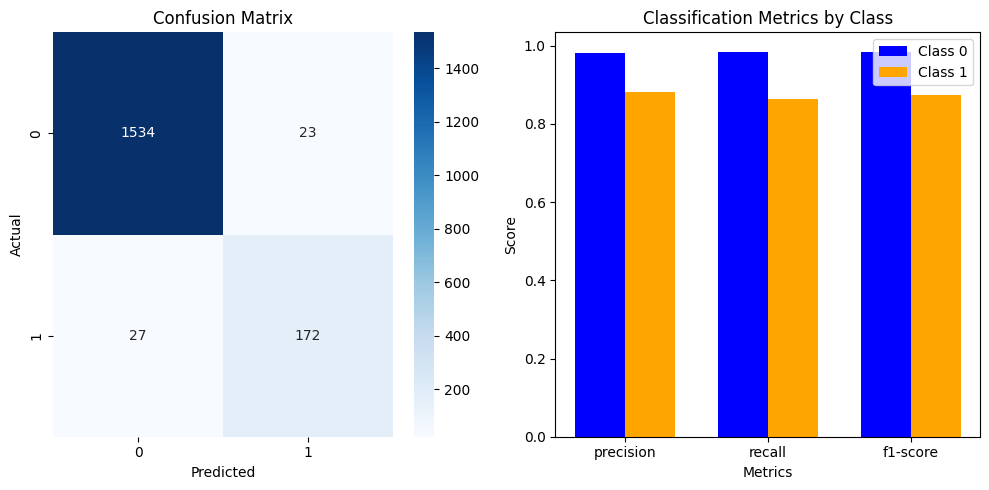

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Load the trained model (assumes the model is saved in .keras format)
model = tf.keras.models.load_model('/content/drive/MyDrive/Trained_Models/trained_model_f16.keras')  # Change path if needed

# Predict on the test data
predictions = model.predict(X_test)

# Convert probabilities to class labels (1 if probability > 0.5, else 0)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Classification Report (precision, recall, f1-score)
report = classification_report(y_test, predicted_labels, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

# Plotting the confusion matrix
plt.figure(figsize=(10, 5))

# Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Bar Plot for Metrics
plt.subplot(1, 2, 2)
metrics = ['precision', 'recall', 'f1-score']
classes = ['Class 0', 'Class 1']
class_0_metrics = [report['0'][metric] for metric in metrics]
class_1_metrics = [report['1'][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, class_0_metrics, width, label='Class 0', color='blue')
plt.bar(x + width/2, class_1_metrics, width, label='Class 1', color='orange')

plt.title("Classification Metrics by Class")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()


# 0.25s of audio duration

In [ ]:
import numpy as np

# Define the segment length
segment_length = 4000

# Reshape X_data to split each 16000-sample array into four 4000-sample arrays
X_data_split = X_data.reshape(-1, 4, segment_length, 1)  # Shape: (num_original_samples, 4, 4000, 1)

# Reshape into a 2D array where each row is a 4000-sample segment
X_data_split = X_data_split.reshape(-1, segment_length, 1)  # Shape: (num_original_samples * 4, 4000, 1)

# Repeat each label 4 times to match the split arrays
y_data_split = np.repeat(y_data, 4)  # Shape: (num_original_samples * 4,)

# Print the new shapes
print("Shape of X_data_split:", X_data_split.shape)  # Should be (total_samples * 4, 4000, 1)
print("Shape of y_data_split:", y_data_split.shape)  # Should be (total_samples * 4,)


NameError: name 'X_data' is not defined

In [ ]:
import os
import numpy as np

# Define paths
base_dir = '/content/drive/MyDrive/TinyML_Dataset/25ms_Dataset/'
X_data_25ms_path = os.path.join(base_dir, 'X_data_split.npy')
y_data_25ms_path = os.path.join(base_dir, 'y_data_split.npy')

# Create the directory if it does not exist
os.makedirs(base_dir, exist_ok=True)

# Save X_data and y_data to Google Drive
np.save(X_data_25ms_path, X_data_split)
np.save(y_data_25ms_path, y_data_split)

print("Data saved to Google Drive successfully.")


Data saved to Google Drive successfully.


## 0.25s model configuration

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Model configuration
input_shape = (4000, 1)
num_classes = 2  # Binary classification ("yes_drone" and "no_drone")

# Build the model
model2 = Sequential()

# Reshape layer
model2.add(Reshape((4000, 1), input_shape=input_shape))

# Convolutional Layers with Pooling
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model2.add(AveragePooling1D(pool_size=2))
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model2.add(AveragePooling1D(pool_size=2))
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model2.add(AveragePooling1D(pool_size=2))
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model2.add(AveragePooling1D(pool_size=2))

# Dropout for regularization
model2.add(Dropout(0.2))  # Increased dropout rate

# Flattening and Dense layers
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Reduced size, added L2 regularization
model2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # L2 regularization added

# Compile the model with binary crossentropy for binary classification
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 4000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 3998, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_4                  │ (None, 1999, 32)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 1997, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_5                  │ (None, 998, 64)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 996, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_6                  │ (None, 498, 128)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 496, 128)            │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_7                  │ (None, 248, 128)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 248, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 31744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,063,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,143,809 (15.81 MB)

 Trainable params: 4,143,809 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

## 0.25s spliting Dataset into: Training, Validation and Test

In [ ]:
from sklearn.model_selection import train_test_split

# Define paths for saving the data
X_data_path = '/content/drive/MyDrive/TinyML_Dataset/25ms_Dataset/X_data_split.npy'
y_data_path = '/content/drive/MyDrive/TinyML_Dataset/25ms_Dataset/y_data_split.npy'

# Load X_data and y_data from Google Drive
X_data = np.load(X_data_path)
y_data = np.load(y_data_path)

print("Data loaded from Google Drive successfully.")
print("Shape of X_data:", X_data.shape)
print("Shape of y_data:", y_data.shape)

# Step 1: Split into 85% train+validation and 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42)

# Step 2: Split train+validation (85%) into 70% training and 15% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)
# 0.1765 because 15% / 85% ≈ 0.1765

# Print shapes of the splits
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


Data loaded from Google Drive successfully.
Shape of X_data: (46816, 4000, 1)
Shape of y_data: (46816,)
Training data shape: (32769, 4000, 1)
Validation data shape: (7024, 4000, 1)
Test data shape: (7023, 4000, 1)


## 0.25s model training

In [ ]:
# Train the model on training and validation data
batch_size = 100 # Adjust based on memory availability
epochs = 100   # Number of epochs for training

history = model2.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),  # Validation data for monitoring
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.8825 - loss: 0.5399 - val_accuracy: 0.8844 - val_loss: 0.2803
Epoch 2/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.9115 - loss: 0.2453 - val_accuracy: 0.9153 - val_loss: 0.2484
Epoch 3/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9323 - loss: 0.2216 - val_accuracy: 0.9369 - val_loss: 0.2009
Epoch 4/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9379 - loss: 0.1974 - val_accuracy: 0.9413 - val_loss: 0.1823
Epoch 5/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9417 - loss: 0.1837 - val_accuracy: 0.9438 - val_loss: 0.1846
Epoch 6/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.9435 - loss: 0.1809 - val_accuracy: 0.9445 - val_loss: 0.1698
Epoch 7/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9468 - loss: 0.1688 - val_accuracy: 0.9445 - val_loss: 0.1780
Epoch 8/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9492 - loss: 0

## Monitoring the model

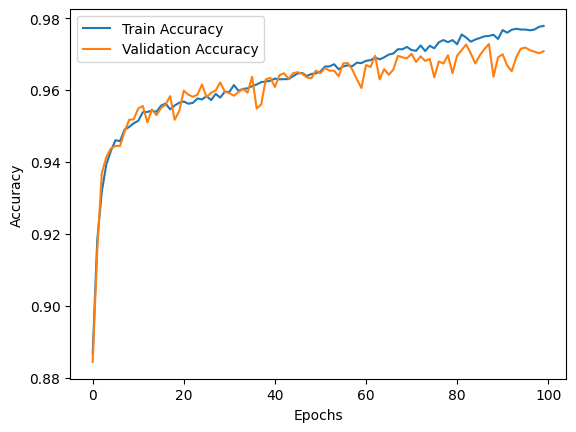

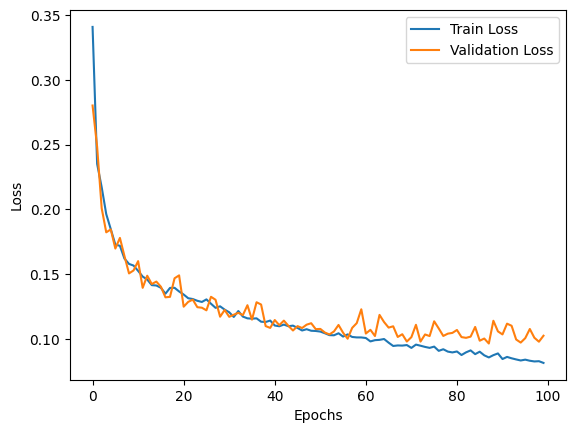

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 25ms model transformation

In [ ]:
model2.save("/content/drive/MyDrive/Trained_Models/trained_model_f25ms.keras")
import tensorflow as tf

# Save the model in a compatible format first
model2.save("/content/drive/MyDrive/Trained_Models/trained_model_f25ms.keras")  # Or use .h5

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = "/content/drive/MyDrive/Trained_Models/trained_model_f25ms.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")

Saved artifact at '/tmp/tmpxprd7en_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4000, 1), dtype=tf.float32, name='keras_tensor_92')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139535099457424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099458000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099457808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099459344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099459152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099460304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099460112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099461264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099458576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099460496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535099458768

## 0.25s

220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Accuracy: 0.9741
Confusion Matrix:
[[6213   50]
 [ 132  628]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6263
           1       0.93      0.83      0.87       760

    accuracy                           0.97      7023
   macro avg       0.95      0.91      0.93      7023
weighted avg       0.97      0.97      0.97      7023



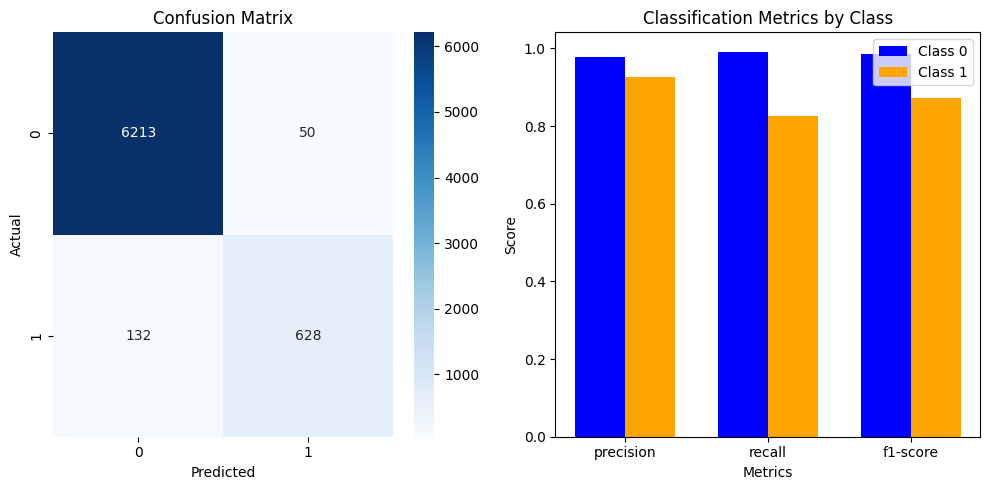

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Load the trained model (assumes the model is saved in .keras format)
model = tf.keras.models.load_model('/content/drive/MyDrive/Trained_Models/trained_model_f25ms.keras')  # Change path if needed

# Predict on the test data
predictions = model.predict(X_test)

# Convert probabilities to class labels (1 if probability > 0.5, else 0)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Classification Report (precision, recall, f1-score)
report = classification_report(y_test, predicted_labels, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

# Plotting the confusion matrix
plt.figure(figsize=(10, 5))

# Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Bar Plot for Metrics
plt.subplot(1, 2, 2)
metrics = ['precision', 'recall', 'f1-score']
classes = ['Class 0', 'Class 1']
class_0_metrics = [report['0'][metric] for metric in metrics]
class_1_metrics = [report['1'][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, class_0_metrics, width, label='Class 0', color='blue')
plt.bar(x + width/2, class_1_metrics, width, label='Class 1', color='orange')

plt.title("Classification Metrics by Class")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()


# RNN models


## LSTM model with 1s

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Model configuration
input_shape = (16000, 1)  # Audio signal input shape
num_classes = 2  # Binary classification ("yes_drone" and "no_drone")

# Build the RNN model
model2 = Sequential()

# Reshape layer
model2.add(Reshape((16000, 1), input_shape=input_shape))

# LSTM layers
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))  # Regularization
model2.add(LSTM(units=128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=128))  # Final LSTM layer without return_sequences
model2.add(Dropout(0.2))

# Fully connected layers
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the model with binary crossentropy for binary classification
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 16000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16000, 64)           │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16000, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16000, 128)          │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16000, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,937 (1.01 MB)

 Trainable params: 263,937 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

## spliting dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Define paths for saving the data
X_data_path = '/content/drive/MyDrive/TinyML_Dataset/X_data.npy'
y_data_path = '/content/drive/MyDrive/TinyML_Dataset/y_data.npy'

# Load X_data and y_data from Google Drive
X_data = np.load(X_data_path)
y_data = np.load(y_data_path)

print("Data loaded from Google Drive successfully.")
print("Shape of X_data:", X_data.shape)
print("Shape of y_data:", y_data.shape)

# Step 1: Split into 85% train+validation and 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42)

# Step 2: Split train+validation (85%) into 70% training and 15% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)
# 0.1765 because 15% / 85% ≈ 0.1765

# Print shapes of the splits
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Data loaded from Google Drive successfully.
Shape of X_data: (11704, 16000, 1)
Shape of y_data: (11704,)
Training data shape: (8192, 16000, 1)
Validation data shape: (1756, 16000, 1)
Test data shape: (1756, 16000, 1)


## Training the model

In [ ]:
# Train the RNN model on training and validation data
batch_size = 50  # Adjust based on memory availability
epochs = 10   # Number of epochs for training

history = model2.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),  # Validation data for monitoring
    verbose=1
)

# Evaluate the trained RNN model on the test set
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8819 - loss: 1.1573 - val_accuracy: 0.8924 - val_loss: 0.4127
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.8876 - loss: 0.4010 - val_accuracy: 0.8924 - val_loss: 0.3574
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8819 - loss: 0.3787 - val_accuracy: 0.8924 - val_loss: 0.3525
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.8889 - loss: 0.3605 - val_accuracy: 0.8924 - val_loss: 0.3500
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.8817 - loss: 0.3735 - val_accuracy: 0.8924 - val_loss: 0.3486
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8769 - loss: 0.3803 - val_accuracy: 0.8924 - val_loss: 0.3517
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8827 - loss: 0.3691 - val_accuracy: 0.8924 - val_loss: 0.3476
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.8890 - loss: 0.3569 - val_accu

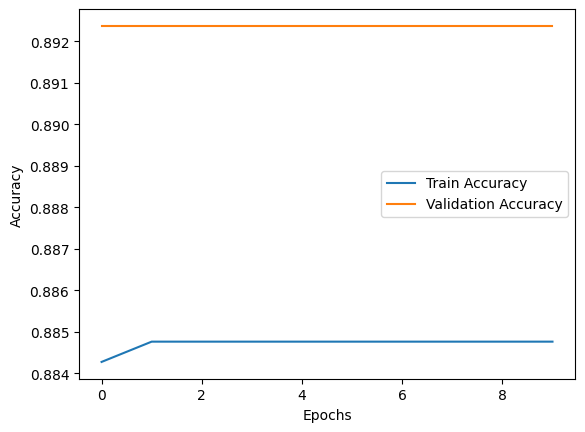

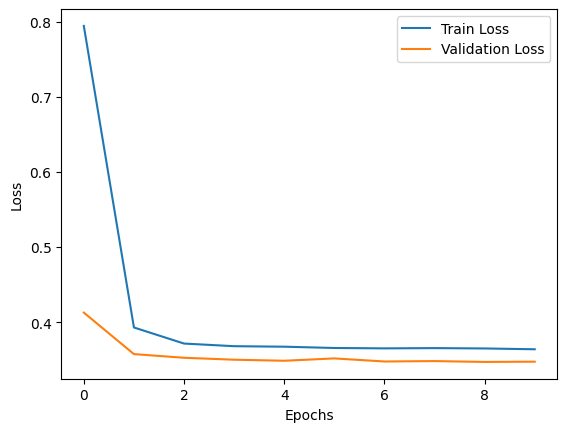

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()